In [1]:
# Import Packages
import IPython.display as ipd

def play_audio(samples):
    return ipd.Audio(samples.data, rate=samples.sample_rate)

In [2]:
from torchcodec.decoders import AudioDecoder

In [3]:
# Define Filepaths, create Audio Decoders
debussy_fp = "./audio/debussy.wav"
duke_fp = "./audio/duke.wav"
redhot_fp = "./audio/redhot.wav"

debussy_decoder = AudioDecoder(debussy_fp)
duke_decoder = AudioDecoder(duke_fp)
redhot_decoder = AudioDecoder(redhot_fp)

In [4]:
# Get AudioSample objects, maybe display a file
debussy = debussy_decoder.get_all_samples()
duke = duke_decoder.get_all_samples()
redhot = redhot_decoder.get_all_samples()

# All tensors of dims [num_channels, num_samples]
# In this case [1, 22050*30]

y_debussy, sr = debussy.data, debussy.sample_rate
y_duke = duke.data
y_redhot = redhot.data

In [5]:
# Define function for zero crossing rate
import torch
import torch.nn.functional as F

def zero_crossing_rate(signal, window_size, hop_size, normalized=True):
    W, H = window_size, hop_size
    L = signal.size(-1)

    N = torch.ceil(torch.tensor(L/H)).int()

    res = torch.zeros((*signal.shape[:-1], N))
    signal_sign = torch.where(signal>=0, 1, -1)     # Not exactly the sign function, but this should work too. Can use `torch.sign()` for exact behaviour.
    signal_change = torch.abs(torch.diff(signal_sign))

    for i in range(N):
        res[..., i] = torch.sum(signal_change[..., i*H:i*H+W])//2
        if normalized:
            res[..., i]/=window_size        # To match librosa's implementation, normalized by frame size
    
    return res

In [6]:
# Get Zero Crossing Rates for all signals
window_size=1024; hop_size=512
debussy_zcr = zero_crossing_rate(y_debussy, window_size=window_size, hop_size=hop_size)
duke_zcr = zero_crossing_rate(y_duke, window_size=window_size, hop_size=hop_size)
redhot_zcr = zero_crossing_rate(y_redhot, window_size=window_size, hop_size=hop_size)

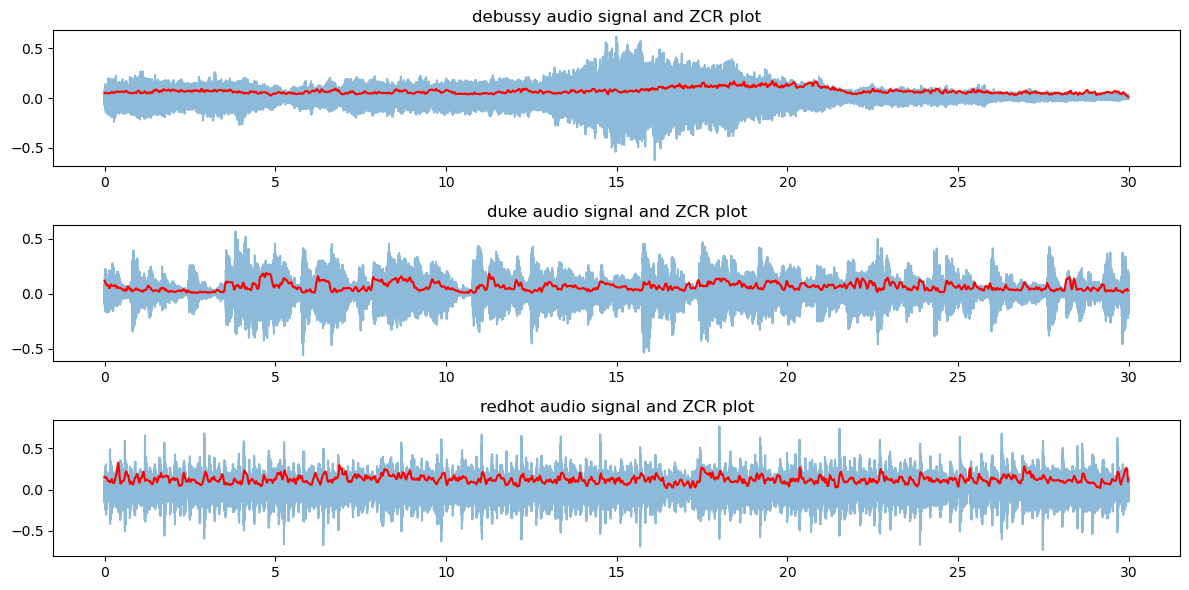

In [7]:
# Plot signals with their zero crossing rates
import matplotlib.pyplot as plt
alpha=0.5
t = torch.arange(y_debussy.size(-1))/sr
t_zcr = torch.arange(debussy_zcr.size(-1))*hop_size/sr

def plot_signal_and_zcr(subplot_id, name, t, signal, t_zcr, signal_zcr):
    plt.subplot(3,1,subplot_id)
    plt.plot(t, signal, label=name, alpha=alpha)
    plt.plot(t_zcr, signal_zcr, label=f"{name} ZCR", linestyle="-", color='r')
    plt.title(f"{name} audio signal and ZCR plot")

plt.figure(figsize=(12,6))
plot_signal_and_zcr(1, "debussy", t,  y_debussy[0], t_zcr, debussy_zcr[0])
plot_signal_and_zcr(2, "duke", t,  y_duke[0], t_zcr, duke_zcr[0])
plot_signal_and_zcr(3, "redhot", t,  y_redhot[0], t_zcr, redhot_zcr[0])
plt.tight_layout()
plt.show()

In [8]:
# Compare voice and noise ZCR
voice_fp = "./audio/voice.wav"
noise_fp = "./audio/noise.wav"

# Get decoders
voice_decoder = AudioDecoder(voice_fp)
noise_decoder = AudioDecoder(noise_fp, sample_rate=22050) # Had to be downsampled from 48kHz, also has two channels but we only plot the first channel

# Get samples from 0 to 15s
voice = voice_decoder.get_samples_played_in_range(start_seconds=0, stop_seconds=15)
noise = noise_decoder.get_samples_played_in_range(start_seconds=0, stop_seconds=15)

# Get signal and sr
y_voice, sr = voice.data, voice.sample_rate
y_noise = noise.data

# Get Zero Crossing Rate
voice_zcr = zero_crossing_rate(y_voice, window_size=window_size, hop_size=hop_size)
noise_zcr = zero_crossing_rate(y_noise, window_size=window_size, hop_size=hop_size)

# Plot
t = torch.arange(y_voice.size(-1))/sr
t_zcr = torch.arange(voice_zcr.size(-1))*hop_size/sr

plt.figure(figsize=(16, 4))
plt.plot(t_zcr, voice_zcr[0], label="voice", linestyle="-", color="r")
plt.plot(t_zcr, noise_zcr[0], label="noise channel 2", linestyle="-", color="g")
# plt.plot(t_zcr, noise_zcr[1], label="noise channel 1", linestyle="-", color="b") # This channel has exact same zcr as first channel
plt.ylim(0,1)
plt.title("Zero Crossing Rate Comparison")
plt.legend()
plt.show()